In [7]:
import SimpleITK as sitk
import numpy as np

class Metadata():
    def __init__(self, origen=None, spacing=None, direction=None):
        self.origen = origen
        self.spacing = spacing
        self.direction = direction
       
    def readNifty(filePath,CoordinateOrder='xyz'):
        image = sitk.ReadImage(filePath)
        print("Reading Nifty format from {}".format(filePath))
        print("Image size: {}".format(image.GetSize()))

        metadata = Metadata(image.GetOrigin(), image.GetSpacing(), image.GetDirection())

        # Converting from SimpleITK image to Numpy array. But also is changed the coordinate systems
        # from the image which use (x,y,z) to the array using (z,y,x).
        volume_zyx = sitk.GetArrayFromImage(image)
        if CoordinateOrder=='xyz':
            volume_xyz = np.transpose(volume_zyx, (2, 1, 0))  # to back to the initial xyz coordinate system.
        else:
            volume_xyz=volume_zyx

        print("Volume shape: {}".format(volume_xyz.shape))
        print("Minimum value: {}".format(np.min(volume_xyz)))
        print("Maximum value: {}".format(np.max(volume_xyz)))

        return volume_xyz, metadata     # return two items.

    def saveNifty(volume, metadata, filename,CoordinateOrder='xyz'):
        # Converting from Numpy array to SimpleITK image.
        if CoordinateOrder=='xyz':
            volume = np.transpose(volume, (2, 1, 0)) # from (x,y,z) to (z,y,x)
        image = sitk.GetImageFromArray(volume)  # It is supposed that GetImageFromArray receive an array with (z,y,x)

        if metadata is not None:
            # Setting some properties to the new image
            image.SetOrigin(metadata.origen)
            image.SetSpacing(metadata.spacing)
            image.SetDirection(metadata.direction)

        sitk.WriteImage(image, filename)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import sys
        
class VolumeCutBrowser():
    def __init__(self,IMS,idx=None,IMSSeg=None,Cut='SA'):
        self.IMS=IMS
        self.idx=idx
        self.IMSSeg=IMSSeg
        self.drawContour=True
        self.Cut=Cut
        if IMSSeg is None:
            self.drawContour=False

        if idx is None:
            if self.Cut=='SA':
                self.idx=np.int(np.round(self.IMS.shape[2]/2))
            elif self.Cut=='Sag':
                self.idx=np.int(np.round(self.IMS.shape[0]/2))
            elif self.Cut=='Cor': 
                self.idx=np.int(np.round(self.IMS.shape[1]/2))
        self.fig, self.ax = plt.subplots()
        self.fig.canvas.mpl_connect('key_press_event', self.press)
        self.DrawScene()

    def press(self,event):
        sys.stdout.flush()
        if event.key == 'x':
            self.idx-=1
            self.idx=max(0,self.idx)
            self.DrawScene()
        if event.key == 'z':
            self.idx+=1

            if self.Cut=='SA':
                Mx=self.IMS.shape[2]-1
            elif self.Cut=='Sag':
                Mx=self.IMS.shape[0]-1
            elif self.Cut=='Cor': 
                Mx=self.IMS.shape[1]-1

            self.idx=min(Mx,self.idx)
            self.DrawScene()


    def DrawScene(self):
        self.ax.cla()

        if self.Cut=='SA':
            Im=self.IMS[:,:,self.idx]
        elif self.Cut=='Sag':
            Im=np.squeeze(self.IMS[self.idx,:,:])
        elif self.Cut=='Cor':    
            Im=np.squeeze(self.IMS[:,self.idx,:])


        self.ax.imshow(Im,cmap='gray')
        self.ax.set_title('Cut: '+ str(self.idx) +' Press "x" to decrease; "z" to increase')
        if self.drawContour:
            if self.Cut=='SA':
                Im=self.IMSSeg[:,:,self.idx]
            elif self.Cut=='Sag':
                Im=np.squeeze(self.IMSSeg[self.idx,:,:])
            elif self.Cut=='Cor':    
                Im=np.squeeze(self.IMSSeg[:,self.idx,:])
            self.ax.contour(Im,[0.5],colors='r')

        self.fig.canvas.draw()
        plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

# SessionPyFolder='/Users/verenaojeda/RICSE/data_analysis/VisualizationCode'

SessionDataFolder='/Users/verenaojeda/RICSE/data_analysis/SampleDataset'
os.chdir(SessionDataFolder)

CaseFolder='CT'
NiiFile='LIDC-IDRI-0001.nii.gz'
NiiFile2='LIDC-IDRI-0001_R_1.nii.gz'

#### Load Intensity Volume
NiiFile=os.path.join(SessionDataFolder,CaseFolder,'image',NiiFile)
niivol,niimetada=readNifty(NiiFile)
#### Load Nodule Mask
NiiFile2=os.path.join(SessionDataFolder,CaseFolder,'nodule_mask',NiiFile2)
niimask,niimetada=readNifty(NiiFile2)

######## VOLUME METADATA
print('Voxel Resolution (mm): ', niimetada.spacing)
print('Volume origin (mm): ', niimetada.origen)
print('Axes direction: ', niimetada.direction)
######## VISUALIZE VOLUMES

Reading Nifty format from /Users/verenaojeda/RICSE/data_analysis/SampleDataset/CT/image/LIDC-IDRI-0001.nii.gz
Image size: (512, 512, 133)
Volume shape: (512, 512, 133)
Minimum value: -2048
Maximum value: 3071
Reading Nifty format from /Users/verenaojeda/RICSE/data_analysis/SampleDataset/CT/nodule_mask/LIDC-IDRI-0001_R_1.nii.gz
Image size: (512, 512, 133)
Volume shape: (512, 512, 133)
Minimum value: 0
Maximum value: 1
Voxel Resolution (mm):  (0.703125, 0.703125, 2.5)
Volume origin (mm):  (-166.0, -171.6999969482422, -340.0)
Axes direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


/var/folders/44/jm95smj11xqbbhxbyy1ffqz80000gn/T/ipykernel_40918/4046600964.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.idx=np.int(np.round(self.IMS.shape[2]/2))


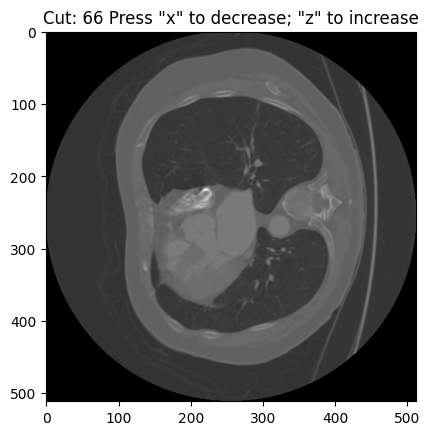

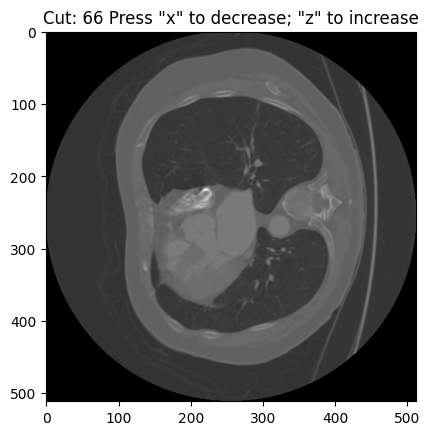

/var/folders/44/jm95smj11xqbbhxbyy1ffqz80000gn/T/ipykernel_40918/4046600964.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.idx=np.int(np.round(self.IMS.shape[1]/2))


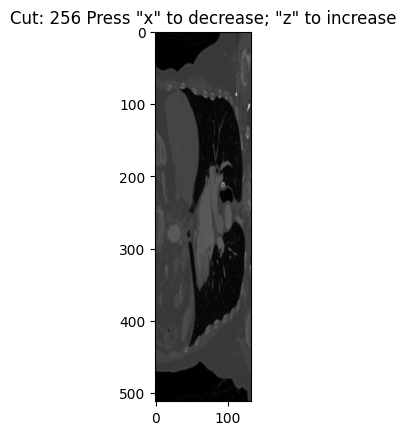

/var/folders/44/jm95smj11xqbbhxbyy1ffqz80000gn/T/ipykernel_40918/4046600964.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.idx=np.int(np.round(self.IMS.shape[0]/2))


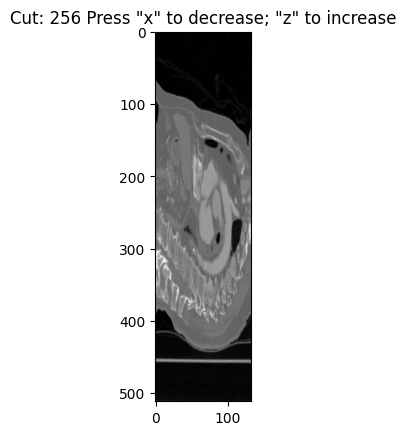

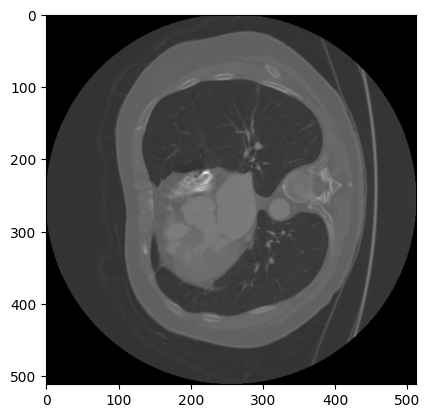

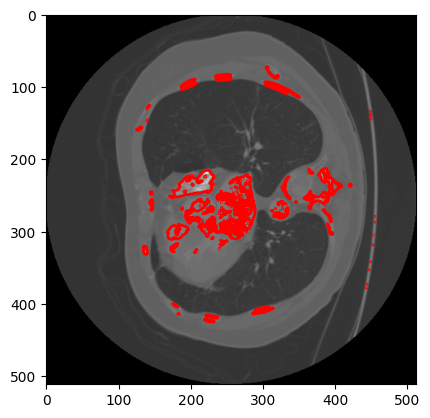

In [27]:
### Interactive Volume Visualization 
# Short Axis View
VolumeCutBrowser(niivol)
VolumeCutBrowser(niivol, IMSSeg=niimask)
# Coronal View
VolumeCutBrowser(niivol, Cut='Cor')
# Sagital View
VolumeCutBrowser(niivol, Cut='Sag')

### Short Axis (SA) Image 
# Define SA cut
k=int(niivol.shape[2]/2) # Cut at the middle of the volume 
SA=niivol[:,:,k]
# Image
fig1=plt.figure()
plt.imshow(SA,cmap='gray')
# plt.close(fig1) #close figure fig1

# Cut Level Sets
levels=[400]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111,aspect='equal') 
ax1.imshow(SA,cmap='gray')
plt.contour(SA,levels,colors='r',linewidths=2)
# plt.close("all") #close all plt figures